# Hydra.jl tutorial

This tutorial is part of the initial release (v0.1.0), submitted to the package registry on June 2nd 2024.

In [12]:
using Pkg; Pkg.activate("test")

  Activating project at `c:\Users\simon\Documents\Julia\Hydra\test`


Hydra is a modelling framework to apply modular approaches to the modelling of exotoxicological effects of chemicals and other stressors. The core model which is currently provided is a reserveless Dynamic Energy Budget (DEB) model akin to DEBkiss. <br>

By default, maturity is included, ingestion and assimilation are simulated explicitly and all state variables (including structure) are expressed in the same dimension. <br>

However,the details of the implemented model are not the important part. The whole point of `Hydra.jl` is that it allows you to modify the model and combine different models. In that sense, it follows a similar philosophy as the [MATLAB BYOM package](https://www.debtox.info/byom.html), but takes a very different approach in realizing it.  <br>

The following examples should give an idea about of `Hydra.jl` works and how it can be used, but only scratches the surface of what might be possible with modular modelling. 

## Simulating the default parameters

Hydra provides a set of default parameters which can be used to simulate . 
The parameters roughly describe the life-history of *Daphnia magna* with model currency $\mu g C$, but have no further importance except that they serve as a starting point. <br>

The following is the minimal code to run a simulation using Hydra:


In [13]:
using Hydra

theta = DEBParamCollection() # we use "theta" to denote parameters
yhat = simulator(theta); # and "yhat" to denote simulation output

The output is a DataFrame containing the model trajectories, with major state variables time `t`, structural mass `S`, maturity `H` and reproduction buffer `R`. <br>
We can visualize the result using a plotting libray of our choice:

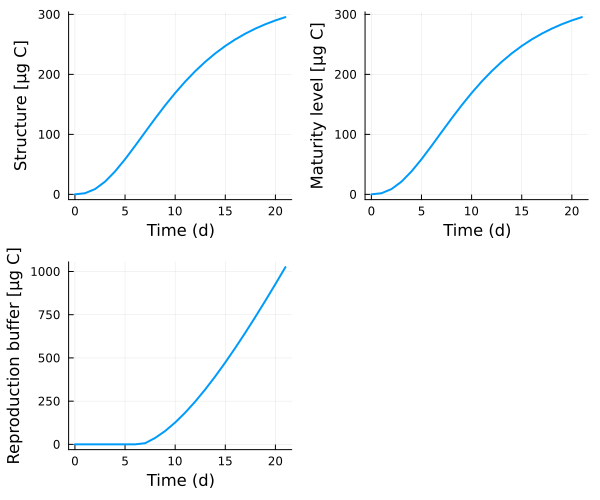

In [14]:
using Plots, StatsPlots
default(leg = false)
@df yhat plot(
    plot(:t, :S, ylabel = "Structure [μg C]"), 
    plot(:t, :S, ylabel = "Maturity level [μg C]"),
    plot(:t, :R, ylabel = "Reproduction buffer [μg C]"), 
    xlabel = "Time (d)", size = (600,500), lw = 2
)

Let's have a closer look at `theta`:

In [15]:
theta

DEBParamCollection
  glb: GlobalParams
  spc: SpeciesParams
  agn: AgentParams


`theta` is a `DEBParamCollection` which in turn contains three parameter objects:

- `glb`: The global parameters, such as simulation time, food influx rate, etc.
- `spc`: The species-specific parameters. This comprises Dynamic Energy Budget (DEB) parameters, Toxicokinetic-Toxicodynamic (TKTD) parameters and some auxiliary parameters.
- `agn`: The agent-specific parameters. These are modified internally and we don't need to do anything with them. 

Why do we need `agn` then? Firstly, this alludes to the implementation of agent-based models, which are not part of the current release yet (but coming soon, I promise ;). <br>
Secondly, `agn`  will be used internally when we add individual variability.

## Simulating individual variability

Let's add individual variability then and simultaneously learn how to modify parameters. <br>
To do so, we need to learn more about the `spc` parameters:

In [16]:
theta.spc

SpeciesParams
  Z: Dirac{Float64}
  propagate_zoom: @NamedTuple{X_emb_int::Bool, H_p::Bool, K_X::Bool}
  X_emb_int: Float64 19.42
  K_X: Float64 1.0
  Idot_max_rel: Float64 22.9
  Idot_max_rel_emb: Float64 22.9
  kappa: Float64 0.539
  eta_IA: Float64 0.33
  eta_AS: Float64 0.8
  eta_SA: Float64 0.8
  eta_AR: Float64 0.95
  k_M: Float64 0.59
  k_J: Float64 0.504
  H_p: Float64 100.0
  e_S: Float64 0.5
  b_S: Float64 5.0
  k_D_G: Array{Float64}((1,)) [0.0]
  k_D_M: Array{Float64}((1,)) [0.0]
  k_D_A: Array{Float64}((1,)) [0.0]
  k_D_R: Array{Float64}((1,)) [0.38]
  k_D_h: Array{Float64}((1,)) [0.0]
  drc_functs_G: Array{Function}((1,))
  drc_functs_M: Array{Function}((1,))
  drc_functs_A: Array{Function}((1,))
  drc_functs_R: Array{Function}((1,))
  drc_functs_h: Array{Function}((1,))
  e_G: Array{Float64}((1,)) [1.0e10]
  e_M: Array{Float64}((1,)) [1.0e10]
  e_A: Array{Float64}((1,)) [1.0e10]
  e_R: Array{Float64}((1,)) [167.0]
  e_h: Array{Float64}((1,)) [1.0e10]
  b_G: Array{Float64}

Oof, that's a lot of stuff. But if we ignore the details for now, we see at least that the parameters have different types (Floats, Arrays, etc.).

The first parameter `Z` is the zoom factor. `Hydra.jl` implements the zoom factor as a ratio between the maximum structural masses of two organisms (not the structural length, as for example done in add-my-pet!). <br>

Above we see that `Z` is not just a number, but a distribution, and by default set to a Dirac distribution with value 1. That means that there is no individual variability implied in the parameters. <br>

We can introduce individual variability by setting `Z` to some other distribution. 
Here we need to be careful that the limits of the distribution do not exceed $[0,\infty]$.

In [17]:
using Distributions
theta.spc.Z = Truncated(Normal(1, 0.1), 0, Inf)

Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0.0, upper=Inf)

The same could by the way be achieved like this:

In [18]:
theta = DEBParamCollection( # instantiate the default parameters
    spc = SpeciesParams(Z = Truncated(Normal(1, 0.1), 0, Inf)) # modify the species parameters
)

DEBParamCollection
  glb: GlobalParams
  spc: SpeciesParams
  agn: Nothing nothing


To get a useful output with these parameters, it makes sense to run multiple realizations of the parameters. <br>
The `@replicates` macro makes this easy:

In [19]:
yhat = @replicates simulator(theta) 10;

Above we have repeated our call to `simulator(theta)` 10 times, each time with a new sample from `Z`. <br>
The results now contain a new column `replicate`, which we can use to tell apart the individuals:

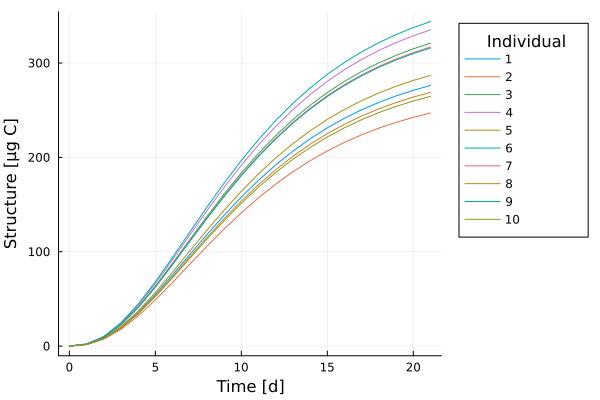

In [20]:
sort!(yhat, :replicate)
@df yhat plot(
    :t, :S, group = :replicate, 
    legend = :outertopright, 
    label = hcat(unique(:replicate)...), 
    legendtitle = "Individual",
    xlabel = "Time [d]", ylabel = "Structure [μg C]")

Hydra also provides the `lineplot` and `groupedlineplot` functions, which can help to visualize this kind of data:

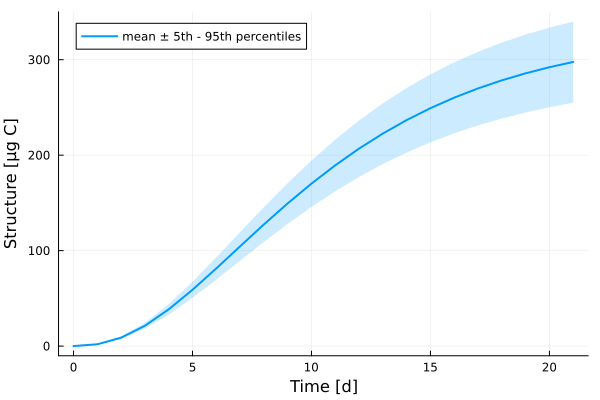

In [21]:
sort!(yhat, :t)
@df yhat lineplot(
    :t, :S, 
    lw = 2, fillalpha = .2, 
    xlabel = "Time [d]", ylabel = "Structure [μg C]", 
    leg = true, label = "mean ± 5th - 95th percentiles"
    )

## Simulating chemical effects

When it comes to simulating chemical effects, `Hydra.jl` introduces some novelties:

- There is no explicit *stress* function. Damage is directly translated in a relative response `y_j`, specific for physiological mode of action (PMoA) `j`. The relative response is whatever we need to multiply with the relevant term(s) to get the assumed response. Differences between PMoAs are dealt with in the definition of the dose-response functions.
- Dose-response functions are not hard-coded, but passed on as model (hyper-)parameters. 
- An arbitrary number of mixture components and combination of PMoAs can be simulated without chaning the model code (we assume independent action by default).

How does this work in practices? Let's start with a simple example.

### Simulating a single stressor

Below we simulate the effects of a single stressor from default parameters (the PMoA is decrease in reproduction efficiency).

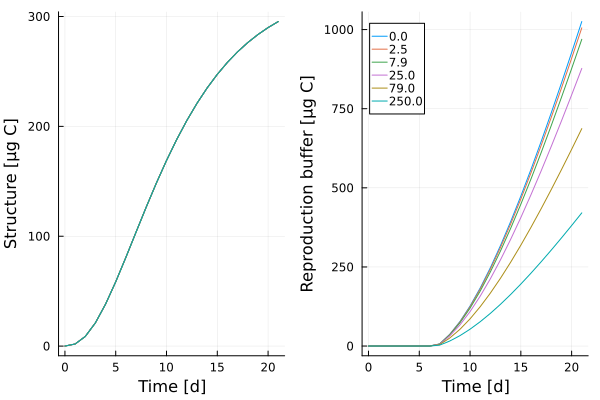

In [22]:
using DataFrames
theta.spc.Z = Dirac(1.) # reset individual variability
C_W = vcat([0.], 10 .^ range(log10(2.5), log10(250), length = 5)) # create a geometric serioes of exposure concentrations

yhat = DataFrame() # instantiate an output object

for c in C_W # for every exposure concentration
    theta.glb.C_W = [c] # update the global parameter
    yhat_c = simulator(theta) # run the simulation
    append!(yhat, yhat_c) # add the result to the output object
end

theta.glb.C_W = [0.] # reset exposure concentration

@df yhat plot( # plot the trajectories
    plot(:t, :S, group = :C_W_1, ylabel = "Structure [μg C]"),
    plot(:t, :R, group = :C_W_1, ylabel = "Reproduction buffer [μg C]", leg = true, 
    label = hcat(unique(round.(:C_W_1, sigdigits = 2))...)), 
    xlabel = "Time [d]"
)

Note that he (constant) exposure concentration `C_W` is a `Vector{Float64}`. Each element corresponds to a mixture component. If we don't want to simulate a mixture, we give only a single value. <br>
In the output, Hydra automatically translates this to a column `C_W_1`, where the suffix `1` corresponds to the position of the mixture component in the input vector.
<br>
By default, we assume log-logistic relaltionships between damage and relative response (for increase in maintenance costs, we use the cumulative hazard function of the log-logistic distribution shifted to intersect the y-axis at a value of 1).

Here we do the same with a different dose-response function, using the often-used linear relationship with a threshold concentration:

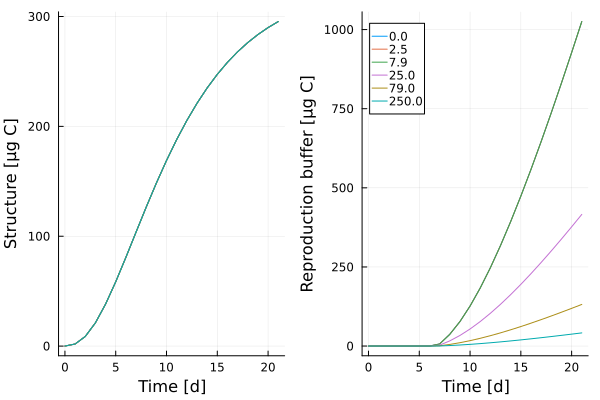

In [23]:
theta.spc.drc_functs_R = [NEC2neg] # use decreasing NEC function instead of log-logistic
theta.spc.e_R = [10.] # adjust the sensitivity parameter (NEC)
theta.spc.b_R = [0.1] # adjust the slope parameter

yhat = DataFrame()

for c in C_W
    theta.glb.C_W = [c]
    yhat_c = simulator(theta)
    append!(yhat, yhat_c)
end

theta.glb.C_W = [0.] # reset exposure concentration

@df yhat plot(
    plot(:t, :S, group = :C_W_1, ylabel = "Structure [μg C]"),
    plot(:t, :R, group = :C_W_1, ylabel = "Reproduction buffer [μg C]", leg = true, 
    label = hcat(unique(round.(:C_W_1, sigdigits = 2))...)), 
    xlabel = "Time [d]"
)

Here we have not simply changed the dose-response *parameters* but passed on a different mathematical formulation for the relationship between damage and effect! The same could be done with any user-defined dose-response function (look at `Hydra/src/DoseResponse.jl` for a collection of examples).

The parameters for different PMoAs are given as seperate vectors, where the suffix indicates the PMoA:

In [24]:
theta.spc.k_D_G # dominant rate constants PMoA G (decrease in growth efficiency)
theta.spc.k_D_M # dominant rate constants PMoA M (increase in maintenance costs)
theta.spc.k_D_A # dominant rate constants PMoA A (decrease in assimilation efficiency)
theta.spc.k_D_R # dominant rate constants PMoA R (decrease in reproduction efficiency)
theta.spc.k_D_h # dominant rate constants PMoA h (hazard rate (GUTS-RED-SD))

theta.spc.e_G # sensitivity parameter PMoA G (decrease in growth efficiency)
theta.spc.e_M # sensitivity parameter PMoA M (increase in maintenance costs)
theta.spc.e_A # sensitivity parameter PMoA A (decrease in assimilation efficiency)
theta.spc.e_R # sensitivity parameter PMoA R (decrease in reproduction efficiency)
theta.spc.e_h # sensitivity parameter PMoA h (hazard rate (GUTS-RED-SD))

theta.spc.b_G # slope parameter PMoA G (decrease in growth efficiency)
theta.spc.b_M # slope parameter PMoA M (increase in maintenance costs)
theta.spc.b_A # slope parameter PMoA A (decrease in assimilation efficiency)
theta.spc.b_R # slope parameter PMoA R (decrease in reproduction efficiency)
theta.spc.b_h # slope parameter PMoA h (hazard rate (GUTS-RED-SD))

1-element Vector{Float64}:
 1.0e10

PMoAs are disengaged by setting the corresponding `k_D`-values to 0 or calling the `Hydra.isolate_pmoas!()` function:

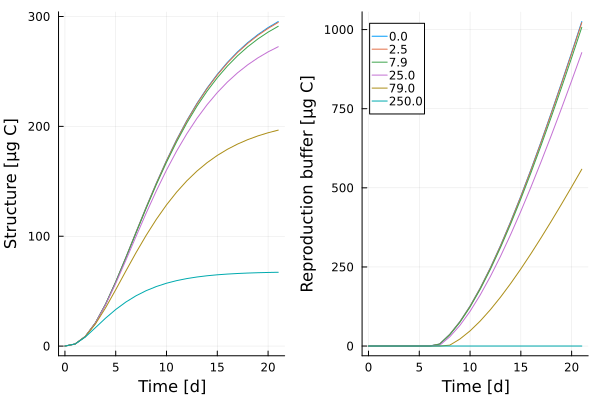

In [25]:
theta.spc.k_D_M = [1.] # engage PMoA M
theta.spc.e_M = [250.] # set parameters for PMoA M
theta.spc.b_M = [1.5]

Hydra.isolate_pmoas!(theta.spc, ["M"]) # disengage all PMoAs but M

yhat = DataFrame()

for c in C_W
    theta.glb.C_W = [c]
    yhat_c = simulator(theta)
    append!(yhat, yhat_c)
end

theta.glb.C_W = [0.] # reset exposure concentration

@df yhat plot(
    plot(:t, :S, group = :C_W_1, ylabel = "Structure [μg C]"),
    plot(:t, :R, group = :C_W_1, ylabel = "Reproduction buffer [μg C]", leg = true, 
    label = hcat(unique(round.(:C_W_1, sigdigits = 2))...)), 
    xlabel = "Time [d]"
)

## Modifying the model equations

We have previosuly learned that in Hydra, the dose-response functions for chemicals are model parameters, 
rather than hard-coded. <br>
The same is actually true for all derivatives of the ODE system! <br>
The functions which apply to individuals are given in the `SpeciesParams`:

In [26]:
theta.spc.odefuncs

12-element Vector{Function}:
 y_z! (generic function with 1 method)
 h_S! (generic function with 1 method)
 Idot! (generic function with 1 method)
 Adot! (generic function with 1 method)
 Mdot! (generic function with 1 method)
 Jdot! (generic function with 1 method)
 Sdot! (generic function with 1 method)
 Hdot! (generic function with 1 method)
 H_bdot! (generic function with 1 method)
 Rdot! (generic function with 1 method)
 Ddot! (generic function with 1 method)
 age! (generic function with 1 method)

And the functions which apply to the global environment are given in the `GlobalParams`:

In [27]:
theta.glb.odefuncs

2-element Vector{Function}:
 C_Wdot_const! (generic function with 1 method)
 X_pdot_chemstat! (generic function with 1 method)

Knowing that, we can modify the model without modifying any of the code in `Hydra.jl`. <br>
Let's say we want to eliminate the DEB assumption that the assimilation efficiency is constant, but instead a function of food uptake (as done first by [Rinke & Vijverberg](https://www.tandfonline.com/doi/pdf/10.1080/03680770.2005.11902020?casa_token=O4jZWN4DznAAAAAA:-lZl_J6RJNbs-1hVSi2I9yY89T2EqiMpD2Wrp_gl-mzRKcak_yiByAZlswsa5Uxar_bFaNuTAx4) and later imitated by [Hansul et al.](https://www.tandfonline.com/doi/pdf/10.1080/03680770.2005.11902020?casa_token=O4jZWN4DznAAAAAA:-lZl_J6RJNbs-1hVSi2I9yY89T2EqiMpD2Wrp_gl-mzRKcak_yiByAZlswsa5Uxar_bFaNuTAx4)). <br>
To do so, we can write a new function for the assimilation flux `Adot!()`:

In [28]:
"""
Calculate food-variable assimilation efficiency. 
"""
function calc_eta_IA!(du, u, p, t)
    p.spc.eta_IA = u.agn.y_A * p.spc.eta_IA_max - (p.spc.eta_IA_max - p.spc.eta_IA_min) * u.agn.f_X
end

calc_eta_IA!

Here we have introduced new parameters `eta_IA_max` and `eta_IA_min`, which are the maximum and minimum assimilation efficiencies, respecitively. <br>
We need to add these to the `SpeciesParams`:

In [56]:
NewParams = Hydra.childstruct(
    SpeciesParams, # structure to which we want to add additional parameters
    [:eta_IA_max, :eta_IA_min],  # names of new parameters
    [Float64, Float64], # types of new parameters
    [0.9, 0.5] # default values of new parameters (taken from Rinke & Vijverberg)
)
spc = NewParams() # instantiate the new parameters
insert!(spc.odefuncs, 4, calc_eta_IA!) # insert new function at a given position
println("$(spc.eta_IA_min), $(spc.eta_IA_max) \n $(spc.odefuncs)") # print the new values

0.5, 0.9 
 Function[Hydra.y_z!, Hydra.h_S!, Hydra.Idot!, calc_eta_IA!, Hydra.Adot!, Hydra.Mdot!, Hydra.Jdot!, Hydra.Sdot!, Hydra.Hdot!, Hydra.H_bdot!, Hydra.Rdot!, Hydra.Ddot!, Hydra.age!]


Listing the new `odefuncs`, we see that we have modified the system so that our `calc_eta_IA()`-function is called after the ingestion flux `Idot!()` and before the assimilation flux `Adot!()`.

In [59]:
spc.odefuncs

13-element Vector{Function}:
 y_z! (generic function with 1 method)
 h_S! (generic function with 1 method)
 Idot! (generic function with 1 method)
 calc_eta_IA! (generic function with 1 method)
 Adot! (generic function with 1 method)
 Mdot! (generic function with 1 method)
 Jdot! (generic function with 1 method)
 Sdot! (generic function with 1 method)
 Hdot! (generic function with 1 method)
 H_bdot! (generic function with 1 method)
 Rdot! (generic function with 1 method)
 Ddot! (generic function with 1 method)
 age! (generic function with 1 method)

Now we can make a parameter collection with our new parameters.

In [61]:
theta = DEBParamCollection(
    spc = NewParams()
)

DEBParamCollection
  glb: GlobalParams
  spc: Hydra.ChildParamType_mgxovuzfys
  agn: Nothing nothing


Let's simulate different food levels to see the new model in action!

In [62]:
using Hydra

In [63]:
theta.spc.odefuncs

13-element Vector{Function}:
 y_z! (generic function with 1 method)
 h_S! (generic function with 1 method)
 Idot! (generic function with 1 method)
 calc_eta_IA! (generic function with 1 method)
 Adot! (generic function with 1 method)
 Mdot! (generic function with 1 method)
 Jdot! (generic function with 1 method)
 Sdot! (generic function with 1 method)
 Hdot! (generic function with 1 method)
 H_bdot! (generic function with 1 method)
 Rdot! (generic function with 1 method)
 Ddot! (generic function with 1 method)
 age! (generic function with 1 method)

In [65]:
Xvec

5-element Vector{Float64}:
  120.0
  213.39352920467076
  379.47331922020555
  674.8095902284189
 1200.0

In [80]:
K_X = p.spc.K_X

1.0

In [81]:
V  =p.glb.V_patch

0.05

In [85]:
X_V = 300 / 0.05

X_V / (X_V + )

6000.0

(1200.0, 1200.0, 0.7058823529411765)
(600.0, 600.0, 0.5454545454545454)
(300.0, 300.0, 0.375)


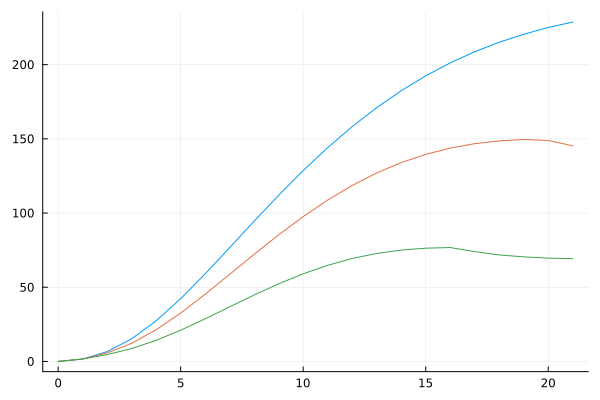

In [86]:
#FIXME: why is Xdot_in not passed on??
p = DEBParamCollection()
p.spc.K_X = 600/0.06

@df simulator(p; alg = Euler(), dt = 1/24) plot(:t, :S)

p.glb.Xdot_in *= 0.5 

@df simulator(p; alg = Euler(), dt = 1/24) plot!(:t, :S)

p.glb.Xdot_in *= 0.5 

@df simulator(p; alg = Euler(), dt = 1/24) plot!(:t, :S)

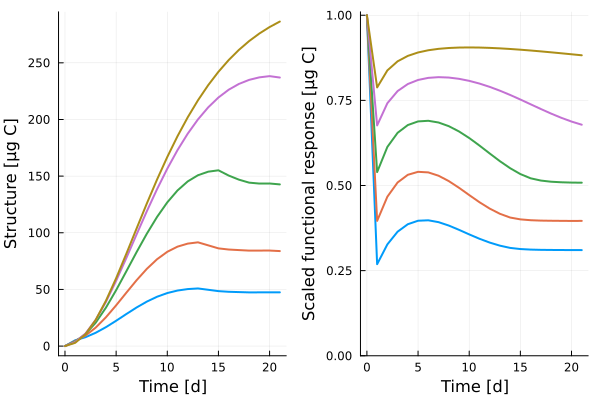

In [99]:
using OrdinaryDiffEq

theta = DEBParamCollection(spc = NewParams(eta_IA_min = 0.33, eta_IA_max = 0.66, K_X = 600/0.05)) # use the new parameters incl. calc_eta_IA!()

function sweep_Xdot_in(theta; Xvec = GlobalParams().Xdot_in .* 10 .^ range(log10(0.1), log10(1.), length = 5))

    yhat = DataFrame() # simulations with variable eta_IA



    for X in Xvec # for every food input rate
        theta.glb.Xdot_in = X # assign parameter
        yhat_X = simulator(theta; alg = Euler(), dt = 1/24) # run simulation
        yhat_X[!,:Xdot_in] .= X # add a column with the food treatment
        append!(yhat, yhat_X) 
    end
    theta.glb.Xdot_in = GlobalParams().Xdot_in # reset to default value

    @df yhat plot(
        plot(:t, :S, group = :Xdot_in, ylabel = "Structure [μg C]"), 
        plot(:t, :f_X, group = :Xdot_in, ylabel = "Scaled functional response [μg C]", ylim = (0,1.01)), 
        lw = 2, xlabel = "Time [d]"
    )
end

sweep_Xdot_in(theta)

To compare this with the output of the default model, we can simply switch back to the old `SpeciesParams`:

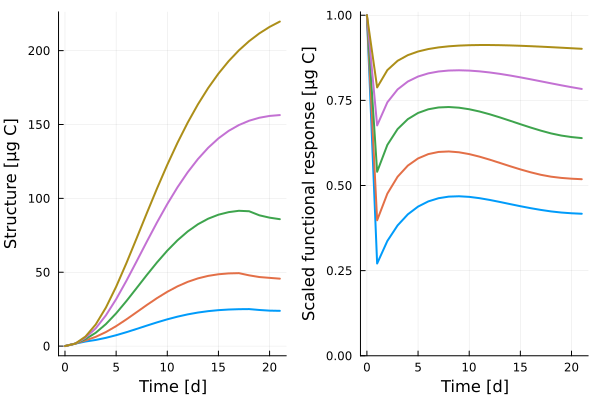

In [100]:
using OrdinaryDiffEq

theta = DEBParamCollection(spc = SpeciesParams(K_X = 600/0.05)) # use the new parameters incl. calc_eta_IA!()
yhat_vareta = DataFrame() # simulations with variable eta_IA
sweep_Xdot_in(theta)

## Notes on performance

`Hydra.jl` aims to provide flexibility and freedom in the modelling process, and ultimately to facilitate **modular modelling** approaches. <br>
Althogh the examples provided here are still quite simple, this freedom probably comes at a price. 
I assume that the practice of treating model functions as hyperparameters comes at a performance disadvantage.  <br>
I have not tested the performance difference between modular implementations and hard-coded models systematically, but my experience with this approach so far tells me that models run fast enough to run various kinds of analyses within reasonable timeframes. <br>
A single simulation of the default parameters with default settings takes about 8ms/

In [104]:
using BenchmarkTools
@benchmark simulator(theta)

BenchmarkTools.Trial: 537 samples with 1 evaluation.
 Range (min … max):  8.325 ms … 33.821 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.741 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.305 ms ±  1.729 ms  ┊ GC (mean ± σ):  4.07% ± 8.94%

  ▅██▇▇▆▅▄▃▃▂ ▁                             ▁▁ ▁              
  ███████████▅██▇▅█▅▅▆▄▅▁▁▄▁▄▁▁▅▁▄▁▁▁▄▅▄▅▇▇███▅█▆▄▆▁▄▄▁▁▁▄▄▄ █
  8.33 ms      Histogram: log(frequency) by time       14 ms <

 Memory estimate: 4.42 MiB, allocs estimate: 215100.

That's a considerable performance decrease compared to hard-coded models, which may run as fast as 1 ms/simulation with the same settings. <br>
However, there are certainly ways to improve the current modular approach in `Hydra.jl`. <br>
In fact, `Hydra.jl` has so far not undergone any performance optimization whatsoever. <br>
We can for example play with the ODE solvers...

In [125]:
using BenchmarkTools
@benchmark simulator(theta; alg = TsitPap8(), saveat = 1) # use 8/7 Tsitouras-Papakostas algorithm 

BenchmarkTools.Trial: 1631 samples with 1 evaluation.
 Range (min … max):  2.660 ms …   8.550 ms  ┊ GC (min … max): 0.00% … 41.16%
 Time  (median):     2.823 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.054 ms ± 768.918 μs  ┊ GC (mean ± σ):  3.65% ±  9.06%

  ██▇▆▅▅▃▃▂▁▁▁▁                                               ▁
  █████████████▇▇▆▇▆▆▅▅▅▄▅▄▄▆▅▁▄▁▅▁▁▅▄▄▁▁▄▁▁▁▁▁▁▁▁▅▁▄▅▅▅▆▆▅▆▇ █
  2.66 ms      Histogram: log(frequency) by time      6.96 ms <

 Memory estimate: 1.43 MiB, allocs estimate: 67115.

...which already changes the computation time by ca -60%.